<a href="https://colab.research.google.com/github/dante161121/telecomX_LATAM1/blob/main/Copia_de_DesafioLatam_telecom1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)


In [2]:
import requests

url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"

# 1) Leer JSON original como lista de diccionarios
json_data = requests.get(url).json()

# 2) Transformación: aplanar estructura anidada usando json_normalize en la lista de diccionarios
df = pd.json_normalize(json_data, sep="_")
df.info()
df.dtypes
# 4) Ahora sí: nulos y duplicados
print("Nulos por columna:")
print(df.isna().sum())

print("\nDuplicados por customerID:")
print(df["customerID"].duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_SeniorCitizen     7267 non-null   int64  
 4   customer_Partner           7267 non-null   object 
 5   customer_Dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_PhoneService         7267 non-null   object 
 8   phone_MultipleLines        7267 non-null   object 
 9   internet_InternetService   7267 non-null   object 
 10  internet_OnlineSecurity    7267 non-null   object 
 11  internet_OnlineBackup      7267 non-null   object 
 12  internet_DeviceProtection  7267 non-null   object 
 13  internet_TechSupport       7267 non-null   objec

Comprobacion de incoherencias


In [11]:
# Comprobación de incoherencias en categorías
cat_cols = [
    "Churn", "gender", "SeniorCitizen", "Partner", "Dependents",
    "PhoneService", "MultipleLines",
    "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport",
    "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]

for c in cat_cols:
    print(f"\n--- {c} ---")
    print(pd.unique(df[c]))



--- Churn ---
['No', 'Yes']
Categories (2, object): ['No', 'Yes']

--- gender ---
['Female', 'Male']
Categories (2, object): ['Female', 'Male']

--- SeniorCitizen ---
[0, 1]
Categories (2, int64): [0, 1]

--- Partner ---
['Yes', 'No']
Categories (2, object): ['No', 'Yes']

--- Dependents ---
['Yes', 'No']
Categories (2, object): ['No', 'Yes']

--- PhoneService ---
['Yes', 'No']
Categories (2, object): ['No', 'Yes']

--- MultipleLines ---
['No', 'Yes', 'No phone service']
Categories (3, object): ['No', 'No phone service', 'Yes']

--- InternetService ---
['DSL', 'Fiber optic', 'No']
Categories (3, object): ['DSL', 'Fiber optic', 'No']

--- OnlineSecurity ---
['No', 'Yes', 'No internet service']
Categories (3, object): ['No', 'No internet service', 'Yes']

--- OnlineBackup ---
['Yes', 'No', 'No internet service']
Categories (3, object): ['No', 'No internet service', 'Yes']

--- DeviceProtection ---
['No', 'Yes', 'No internet service']
Categories (3, object): ['No', 'No internet service',

Manejo de inconsistencias

Corregir los faltantes y asegurar las coherencias por cada categoria.

In [12]:
# Eliminar filas con TotalCharges nulo
df = df.dropna(subset=["TotalCharges"])

# Verificar
df[["tenure", "MonthlyCharges", "TotalCharges"]].isna().sum()
cols_internet = [
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
]

for c in cols_internet:
    df[c] = df[c].replace("No internet service", "No")


/tmp/ipython-input-323/266017653.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[c] = df[c].replace("No internet service", "No")


crear Cuentas_Diarias

In [13]:
# Crear columna de facturación diaria a partir de la facturación mensual
# Suponemos 30 días por mes para el prorrateo

df["Cuentas_Diarias"] = df["MonthlyCharges"] / 30

# Verificar
df[["MonthlyCharges", "Cuentas_Diarias"]].head()
df[["MonthlyCharges", "Cuentas_Diarias"]].describe()


,MonthlyCharges,Cuentas_Diarias
count,7032.000000,7032.000000
mean,64.798208,2.159940
std,30.085974,1.002866
min,18.250000,0.608333
25%,35.587500,1.186250
50%,70.350000,2.345000
75%,89.862500,2.995417
max,118.750000,3.958333


Vamos añadir las variable tipo si o no.

In [14]:
# Mapear categorías a binario 1/0
bin_map = {"Yes": 1, "No": 0}

df["ChurnFlag"] = df["Churn"].map(bin_map)              # ya la tienes, pero lo dejamos consistente
df["Partner_bin"] = df["Partner"].map(bin_map)
df["Dependents_bin"] = df["Dependents"].map(bin_map)
df["PhoneService_bin"] = df["PhoneService"].map(bin_map)
df["PaperlessBilling_bin"] = df["PaperlessBilling"].map(bin_map)

# Para columnas de internet donde ya reemplazaste "No internet service" por "No"
cols_internet = [
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
]

for c in cols_internet:
    df[c + "_bin"] = df[c].map(bin_map)

df.filter(regex="_bin$|ChurnFlag").head()


,ChurnFlag,Partner_bin,Dependents_bin,PhoneService_bin,PaperlessBilling_bin,OnlineSecurity_bin,OnlineBackup_bin,DeviceProtection_bin,TechSupport_bin,StreamingTV_bin,StreamingMovies_bin
0,0,1,1,1,1,0,1,0,1,1,0
1,0,0,0,1,0,0,0,0,0,0,1
2,1,0,0,1,1,0,0,1,0,0,0
3,1,1,0,1,1,0,1,1,0,1,1
4,1,1,0,1,1,0,0,0,1,1,0


enombrar dasasdsadrenombrar coloumnas

In [8]:
# Renombrar columnas importantes
df = df.rename(columns={
    "customer_gender": "gender",
    "customer_SeniorCitizen": "SeniorCitizen",
    "customer_Partner": "Partner",
    "customer_Dependents": "Dependents",
    "customer_tenure": "tenure",
    "phone_PhoneService": "PhoneService",
    "phone_MultipleLines": "MultipleLines",
    "internet_InternetService": "InternetService",
    "internet_OnlineSecurity": "OnlineSecurity",
    "internet_OnlineBackup": "OnlineBackup",
    "internet_DeviceProtection": "DeviceProtection",
    "internet_TechSupport": "TechSupport",
    "internet_StreamingTV": "StreamingTV",
    "internet_StreamingMovies": "StreamingMovies",
    "account_Contract": "Contract",
    "account_PaperlessBilling": "PaperlessBilling",
    "account_PaymentMethod": "PaymentMethod",
    "account_Charges_Monthly": "MonthlyCharges",
    "account_Charges_Total": "TotalCharges"
})

# Variable objetivo
df["Churn"] = df["Churn"].replace("", np.nan)
df = df.dropna(subset=["Churn"])
df["ChurnFlag"] = df["Churn"].map({"No": 0, "Yes": 1}).astype(int)

# Numéricas
df["tenure"] = pd.to_numeric(df["tenure"], errors="coerce")
df["MonthlyCharges"] = pd.to_numeric(df["MonthlyCharges"], errors="coerce")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df[["tenure", "MonthlyCharges", "TotalCharges", "ChurnFlag"]].describe()


,tenure,MonthlyCharges,TotalCharges,ChurnFlag
count,7043.000000,7043.000000,7032.000000,7043.000000
mean,32.371149,64.761692,2283.300441,0.265370
std,24.559481,30.090047,2266.771362,0.441561
min,0.000000,18.250000,18.800000,0.000000
25%,9.000000,35.500000,401.450000,0.000000
50%,29.000000,70.350000,1397.475000,0.000000
75%,55.000000,89.850000,3794.737500,1.000000
max,72.000000,118.750000,8684.800000,1.000000


Verificacion y tipos de datos


In [9]:
print(df.dtypes)

cat_cols = [
    "Churn", "gender", "SeniorCitizen", "Partner", "Dependents",
    "PhoneService", "MultipleLines",
    "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport",
    "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]

for c in cat_cols:
    df[c] = df[c].astype("category")

df.dtypes


customerID           object
Churn                object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
ChurnFlag             int64
dtype: object


,0
customerID,object
Churn,category
gender,category
SeniorCitizen,category
Partner,category
Dependents,category
tenure,int64
PhoneService,category
MultipleLines,category
InternetService,category


Para el conteo de evasión por variables numéricas, vamos a comparar, cada variable numérica, los valores medios y medianas entre clientes con y sin churn.

In [23]:
# Variables numéricas a analizar
num_cols = ["tenure", "MonthlyCharges", "TotalCharges", "Cuentas_Diarias"]

# Tabla resumen: medias por estado de Churn
conteo_num = df.groupby("Churn")[num_cols].mean().round(2)
print("Promedios de variables numéricas por estado de Churn:")
print(conteo_num)


Promedios de variables numéricas por estado de Churn:
       tenure  MonthlyCharges  TotalCharges  Cuentas_Diarias
Churn                                                       
No      37.65           61.31       2555.34             2.04
Yes     17.98           74.44       1531.80             2.48


/tmp/ipython-input-323/3925634560.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteo_num = df.groupby("Churn")[num_cols].mean().round(2)


Este gráfico muestra cuántos clientes cancelan (Yes) frente a los que permanecen (No), permitiendo dimensionar la magnitud del problema de evasión.

Conteo de Churn:
 Churn
No     5163
Yes    1869
Name: count, dtype: int64

Porcentaje de Churn (%):
 Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64


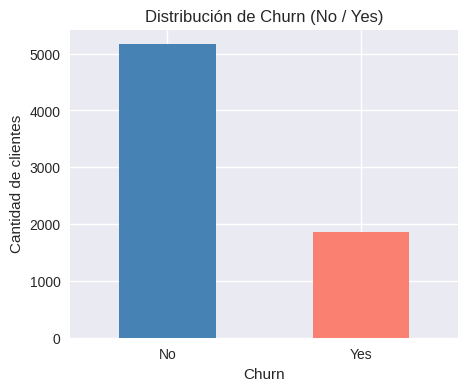

In [15]:
# Distribución de Churn (conteo y porcentaje)
churn_counts = df["Churn"].value_counts()
churn_pct = df["Churn"].value_counts(normalize=True) * 100

print("Conteo de Churn:\n", churn_counts)
print("\nPorcentaje de Churn (%):\n", churn_pct)

plt.figure(figsize=(5,4))
churn_counts.plot(kind="bar", color=["steelblue", "salmon"])
plt.title("Distribución de Churn (No / Yes)")
plt.ylabel("Cantidad de clientes")
plt.xticks(rotation=0)
plt.show()


El boxplot compara los meses de permanencia entre clientes que cancelan y los que permanecen, ayudando a identificar si los que se van tienen menor tiempo en la empresa.

<Figure size 600x400 with 0 Axes>

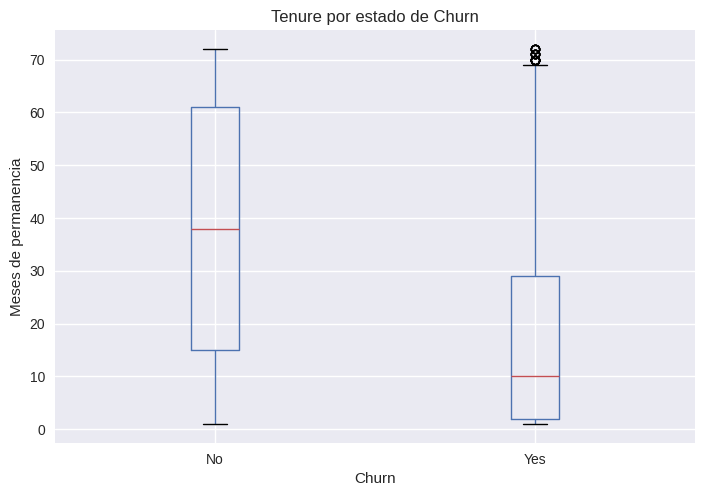

In [16]:
plt.figure(figsize=(6,4))
df.boxplot(column="tenure", by="Churn")
plt.title("Tenure por estado de Churn")
plt.suptitle("")
plt.xlabel("Churn")
plt.ylabel("Meses de permanencia")
plt.show()


Estos gráficos permiten analizar si los clientes que cancelan pagan montos mensuales o acumulados diferentes, lo que puede indicar sensibilidad al precio.

<Figure size 600x400 with 0 Axes>

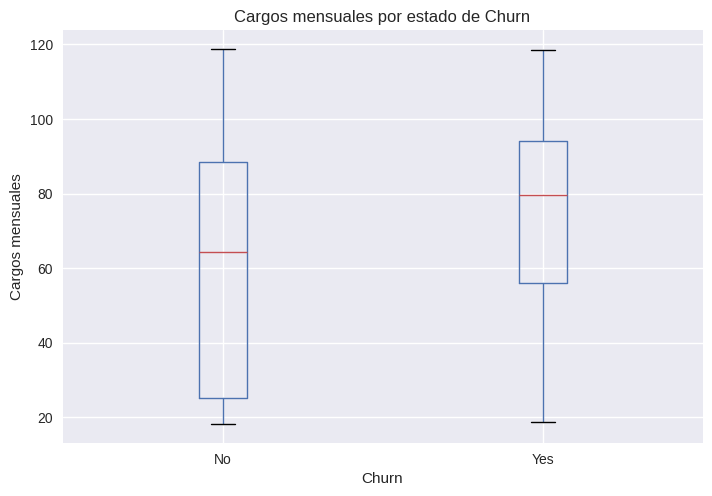

<Figure size 600x400 with 0 Axes>

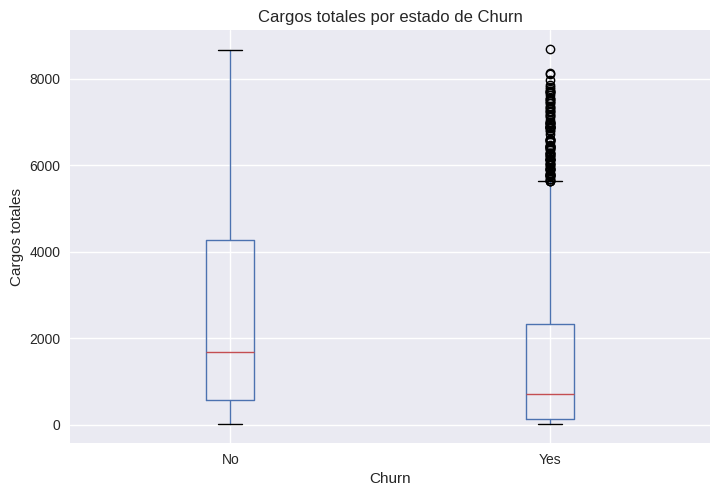

In [17]:
# MonthlyCharges vs Churn
plt.figure(figsize=(6,4))
df.boxplot(column="MonthlyCharges", by="Churn")
plt.title("Cargos mensuales por estado de Churn")
plt.suptitle("")
plt.xlabel("Churn")
plt.ylabel("Cargos mensuales")
plt.show()

# TotalCharges vs Churn
plt.figure(figsize=(6,4))
df.boxplot(column="TotalCharges", by="Churn")
plt.title("Cargos totales por estado de Churn")
plt.suptitle("")
plt.xlabel("Churn")
plt.ylabel("Cargos totales")
plt.show()


Aquí observas qué tipo de contrato (mensual, 1 año, 2 años) presenta mayor porcentaje de cancelaciones, clave para diseñar estrategias comerciales.

Churn                  No        Yes
Contract                            
Month-to-month  57.290323  42.709677
One year        88.722826  11.277174
Two year        97.151335   2.848665


<Figure size 700x400 with 0 Axes>

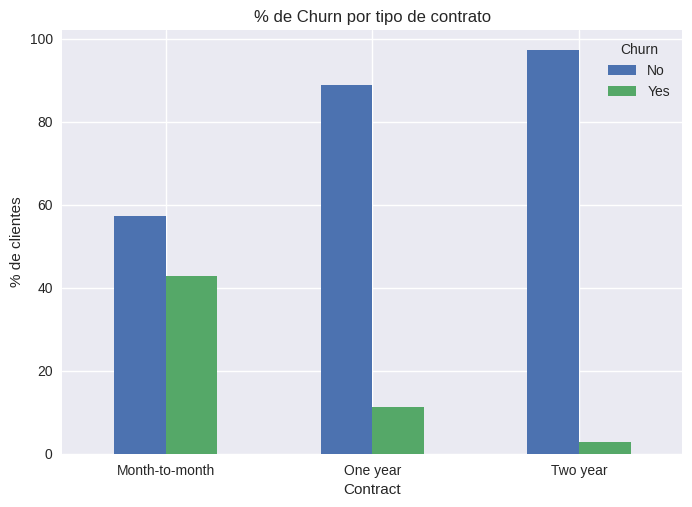

In [18]:
ct_contract = pd.crosstab(df["Contract"], df["Churn"], normalize="index") * 100
print(ct_contract)

plt.figure(figsize=(7,4))
ct_contract.plot(kind="bar")
plt.title("% de Churn por tipo de contrato")
plt.ylabel("% de clientes")
plt.xticks(rotation=0)
plt.show()


Este gráfico revela qué métodos de pago concentran más churn, por ejemplo pagos electrónicos vs transferencias automáticas, lo que orienta cambios en políticas de cobro.

Churn                             No        Yes
PaymentMethod                                  
Bank transfer (automatic)  83.268482  16.731518
Credit card (automatic)    84.746877  15.253123
Electronic check           54.714588  45.285412
Mailed check               80.798005  19.201995


<Figure size 900x400 with 0 Axes>

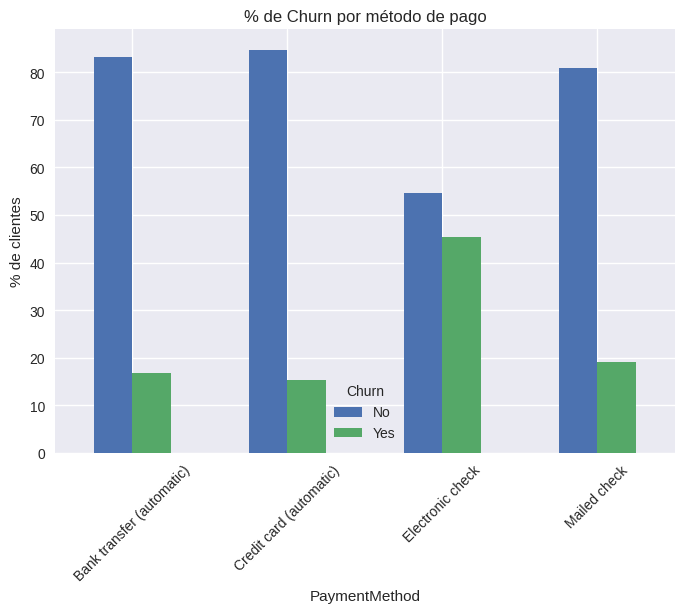

In [19]:
ct_payment = pd.crosstab(df["PaymentMethod"], df["Churn"], normalize="index") * 100
print(ct_payment)

plt.figure(figsize=(9,4))
ct_payment.plot(kind="bar")
plt.title("% de Churn por método de pago")
plt.ylabel("% de clientes")
plt.xticks(rotation=45)
plt.show()


Para el conteo de evasión por variables numéricas, vamos a comparar, cada variable numérica, los valores medios y medianas entre clientes con y sin churn.

In [22]:
# Variables numéricas a analizar
num_cols = ["tenure", "MonthlyCharges", "TotalCharges", "Cuentas_Diarias"]

# Tabla resumen: medias por estado de Churn
conteo_num = df.groupby("Churn")[num_cols].mean().round(2)
print("Promedios de variables numéricas por estado de Churn:")
print(conteo_num)


Promedios de variables numéricas por estado de Churn:
       tenure  MonthlyCharges  TotalCharges  Cuentas_Diarias
Churn                                                       
No      37.65           61.31       2555.34             2.04
Yes     17.98           74.44       1531.80             2.48


/tmp/ipython-input-323/3925634560.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteo_num = df.groupby("Churn")[num_cols].mean().round(2)


Compara el churn entre clientes con DSL, fibra óptica y sin internet, ayudando a identificar si algún tipo de tecnología está más asociado a cancelaciones.

Churn                   No        Yes
InternetService                      
DSL              81.001656  18.998344
Fiber optic      58.107235  41.892765
No               92.565789   7.434211


<Figure size 700x400 with 0 Axes>

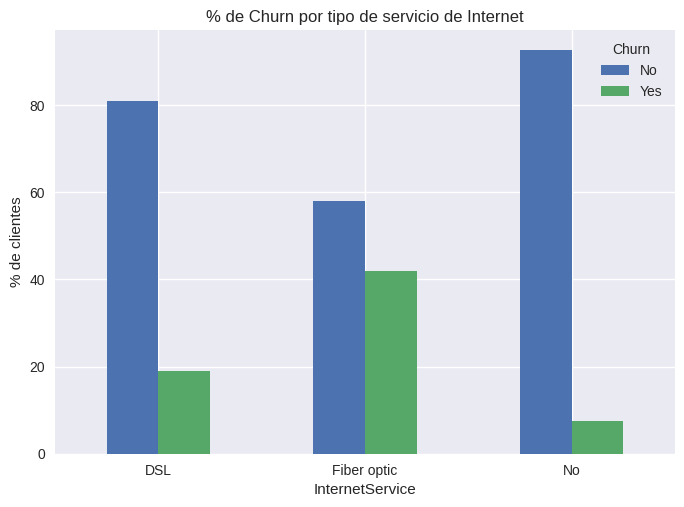

In [20]:
ct_internet = pd.crosstab(df["InternetService"], df["Churn"], normalize="index") * 100
print(ct_internet)

plt.figure(figsize=(7,4))
ct_internet.plot(kind="bar")
plt.title("% de Churn por tipo de servicio de Internet")
plt.ylabel("% de clientes")
plt.xticks(rotation=0)
plt.show()


En este espacio se permite ver si contar con servicios adicionales (como seguridad online) se relaciona con menor churn, lo que puede respaldar ventas cruzadas.

Churn                  No        Yes
OnlineSecurity                      
No              68.626669  31.373331
Yes             85.359801  14.640199


<Figure size 600x400 with 0 Axes>

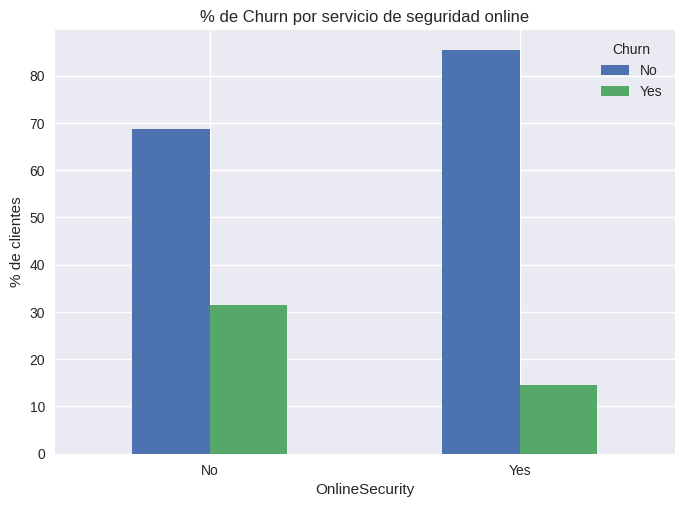

In [21]:
ct_security = pd.crosstab(df["OnlineSecurity"], df["Churn"], normalize="index") * 100
print(ct_security)

plt.figure(figsize=(6,4))
ct_security.plot(kind="bar")
plt.title("% de Churn por servicio de seguridad online")
plt.ylabel("% de clientes")
plt.xticks(rotation=0)
plt.show()


**1. INTODUCCION**

Telecom X está atravesando una situación preocupante y es la siguiente: cerca del 26 % de sus clientes decide cancelar el servicio, lo que significa que aproximadamente uno de cada cuatro usuarios se va, situacion critica. Esta pérdida es muy marcada y constante no solo afecta los ingresos mensuales de la empresa, sino que también debilita la estabilidad y el crecimiento de su base de clientes. Por eso, resulta fundamental entender con claridad quiénes están abandonando la compañía y cuáles son las razones detrás de esa decisión.

Este análisis tiene como propósito principal identificar los factores que están influyendo en la evasión de clientes. Además, busca dejar los datos organizados y listos para la construcción de futuros modelos predictivos que permitan anticipar el churn. Finalmente, a partir de los hallazgos obtenidos, se pretende plantear recomendaciones prácticas y concretas que ayuden a reducir la tasa de abandono y fortalecer la fidelización de los usuarios.


2. **Limpieza y tratamiento de datos**

Para asegurar que el análisis fuera confiable y consistente, se siguió un proceso estructurado de ETL es decir la Extracción, Transformación y Carga. La idea fue partir de los datos en su estado original y convertirlos en una base organizada, clara y lista para el análisis.

**Extracción**
El archivo TelecomX_Data.json se obtuvo directamente desde la URL pública de GitHub utilizando una solicitud con requests.get(url).json().
Como el archivo tenía una estructura JSON anidada, fue necesario transformarlo en un formato tabular. Para ello, se utilizó pd.json_normalize(json_data, sep="_")

**Transformación**

En esta etapa se realizaron varios ajustes importantes:
Se renombraron las columnas técnicas para hacerlas más claras y fáciles de interpretar. Por ejemplo, customer_gender pasó a llamarse gender, account_Contract se simplificó a Contract, y account_Charges_Monthly a MonthlyCharges.

**Se corrigieron los tipos de datos:**

Las variables numéricas como tenure, MonthlyCharges y TotalCharges se convirtieron a formato numérico (int o float) utilizando pd.to_numeric.
Las variables categóricas como gender, Contract, InternetService y PaymentMethod se definieron como tipo category para optimizar su uso en análisis posteriores.

Se trabajó la variable objetivo (Churn):

**Se limpiaron posibles valores vacíos.**

Se creó una nueva variable binaria llamada ChurnFlag, donde No se codificó como 0 y Yes como 1, facilitando así su uso en modelos predictivos.

**Se revisaron inconsistencias y valores especiales:**

En algunos servicios aparecía la categoría "No internet service". Estas categorías se identificaron con pandas.unique() y se unificaron reemplazándolas por "No" cuando correspondía, para evitar duplicidades conceptuales.
Se trataron los valores faltantes:
Se eliminaron las filas donde TotalCharges estaba nulo, ya que representaban pocos registros y dificultaban el análisis numérico.
Estandarización y variables derivadas
Finalmente, se crearon nuevas variables para enriquecer el análisis:
Se creó la variable Cuentas_Diarias, calculada como MonthlyCharges / 30, con el fin de estimar el valor promedio diario facturado a cada cliente.

**Análisis de Churn en Telecom X: Diagnóstico Crítico y Oportunidades de Acción Inmediata**



Telecom X enfrenta una crisis de clientes crítica. Este análisis revela que 1 de cada 4 clientes abandona nuestros servicios, generando una tasa que no solo amenaza nuestra base de usuarios, sino que tambíen representa una pérdida multimillonaria en ingresos recurrentes a la empresa. Este informe no solo mide el problema; expone el la raiz exacta del cliente que se va y nos entrega las palancas estratégicas para detener la fuga de forma inmediata entregando una solucion al problema.

La variable Churn muestra que alrededor del 73 % de los clientes permanece (No) y aproximadamente el 27 % cancela (Yes).  
- Esto confirma que el churn es un problema significativo, pero también ofrece un espacio importante para acciones de retención, ya que la mayoría aún se mantiene activa.

Variables numéricas vs churn

- **Tenure (tiempo de permanencia)**  
  - Los clientes con churn tienen, en promedio, un **tenure mucho menor** (alrededor de 18 meses) frente a los que permanecen (alrededor de 38 meses).  
  - Los boxplots muestran claramente que los que se van suelen estar en los primeros años de relación, lo que indica que los primeros meses son críticos para fidelizar.

Variables categóricas vs churn

- **Tipo de contrato (Contract)**  
  - Los contratos Month-to-month presentan el **mayor porcentaje de churn**, con una proporción de cancelaciones sustancialmente superior a los contratos One year y`Two year.  


**El Perfil del Cliente que deja la empresa**

Se identifica que el cliente de avandona.
1. las cusas podrian ser que no esta comprometido.
2. No cuenta con sericios que le den un valor añadido.
3. ELl cliente que se va es aquel que paga mucho y que no encuentra un valor agregado.



**Estos son los Tres Drivers Fundamentales que considero que están Matando Nuestra Retención**

1. Los servicio premium, como la Fibra Óptica, genera más **churn** que el **DSL.** lo que se denomina un problema de percepción de calidad y expectativas no cumplidas.
2. Los clientes con menor tiempo son los que se van.
3. Pagar con Cheque Electrónico duplica las probabilidades de churn.

**Diseño de estrategia que llama a la accion**

1. Crear campaña de retención proactiva y agresiva dirigida exclusivamente al perfil de riesgo identificado. Ofrecerles paquetes de seguridad y de soporte gratuitos por 6 meses, descuentos por lealtad.
2. Realizar una investigación cualitativa urgente con clientes de Fibra que han hecho churn. Esta INVESTIGACION debera IDENTIFICAR y responder preguntas como ¿Qué falló? ¿Velocidad real vs. anunciada? ¿Atención al cliente? Debemos corregir el producto o la comunicación con el cliente.
3. Revisión de planes de Internet, particularmente fibra óptica  
   - Investigar por qué los clientes con **Fibra Optica** presentan mayores problemas de calidad del servicio, soporte técnico, estabilidad o percepción de precio.  
   - Ajustar el posicionamiento de precio y los paquetes de valor agregado por ejemplo, mayor velocidad, prioridad de soporte para este segmento de alta evasión.
4. Promoción de servicios adicionales de valor como lo son seguridad y soporte  
   - Potenciar la venta cruzada de servicios hacia clientes con perfil de alto riesgo.  
   - Comunicar estos servicios como herramientas para mejorar la experiencia, garantizar estabilidad y respaldo técnico, lo que puede reducir la probabilidad de cancelación.

**Conclucion**

El churn en Telecom X no es una fatalidad como se piensa, es un problema de enfoque. Con los datos podemos predecir quién se va y por qué. Ahora necesitamos la valentía de actuar sobre esas evidencias y transformar nuestra mayor debilidad en nuestra ventaja competitiva.